# RatU Day4SD recording info
- No timestamps were deleted after concatenating .dat files from various folders of open-ephys

In [36]:
import numpy as np
import subjects

sess = subjects.sd.ratUday4[0]
print(sess.recinfo)

filename: /data/Clustering/sessions/RatU/RatUDay4SD/RatU_Day4SD_2021-07-29_08-23-06.xml 
# channels: 192
sampling rate: 30000
lfp Srate (downsampled): 1250


In [13]:
sess.recinfo.channel_groups

array([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
       [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31],
       [32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47],
       [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63],
       [64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
       [80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95],
       [96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109,
        110, 111],
       [112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
        125, 126, 127],
       [128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143],
       [144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
        157, 158, 159],
       [160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172,
        173, 174, 175],
       [176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188,
        189, 190, 

# Set probe configuration
- RatU_Day4SD has two probes: both 128chan-8shanks diagnostic biochips.
- 64 channels in one of the probes (implanted in left hemisphere) had no signal from 4 shanks (probably one of the intan chips was faulty). So only 192 channels were recorded, the channels in .dat file are already order according to depth.

data saved


<AxesSubplot:title={'center':'Probe 192ch'}>

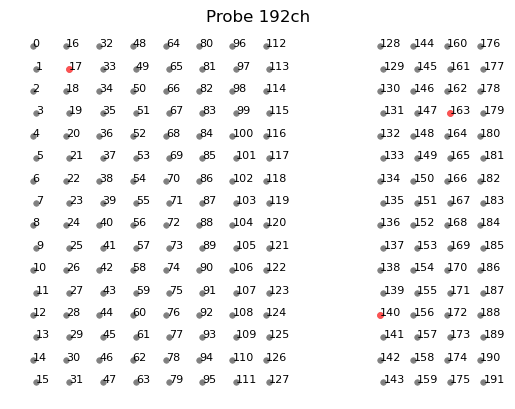

In [11]:
%matplotlib inline
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe

shanks = []
channel_groups = sess.recinfo.channel_groups
badchans = sess.recinfo.skipped_channels

#--- cambridge probe -----------
for i in range(8):
    chans = channel_groups[i]
    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=15,
        y_shift_per_column=[0,-7.5],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)

probe1 = Probe(shanks)

shanks = []
for i in range(8,12):

    shank = Shank.auto_generate(
        columns=2,
        contacts_per_column=8,
        xpitch=15,
        ypitch=15,
        y_shift_per_column=[0, -7.5],
        channel_id=np.append(
            channel_groups[i][::2][::-1], channel_groups[i][1::2][::-1]
        ),
    )
    shank.set_disconnected_channels(sess.recinfo.skipped_channels)
    shanks.append(shank)


probe2 = Probe(shanks)
probe2.move((probe1.x_max+500,0))

prbgrp = ProbeGroup()
prbgrp.add_probe(probe1)
prbgrp.add_probe(probe2)

prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save()
plot_probe(prbgrp)

## Create epochs for your experimental paradigm
- RatS_Day2NSD had digitized noise in first ~2 hours of pre sleep. I somehow didn't notice that while recording, so the pre sleep is a lot shorter comapred to other animals.

In [37]:
sess.paradigm.to_dataframe()

,start,stop,label,duration
0,0,9410,pre,9410
1,9411,12546,maze,3135
2,12547,30564,sd,18017
4,12547,45160,post,32613
3,30565,45160,rs,14595
5,45161,48283,re-maze,3122


In [35]:
import pandas as pd
from neuropy.core import Epoch

datetime_data = pd.read_csv(sess.filePrefix.with_suffix('.datetime.csv'))
durations = datetime_data.nFrames/sess.recinfo.dat_sampling_rate
epochs = pd.DataFrame(
    {
        "start": [0, 9411,12547,30565,12547,45161],
        "stop": [9410, 12546, 30564, 45160,45160,48283],
        "label": ["pre", "maze", "sd",'rs','post','re-maze'],
    }
)

paradigm = Epoch(epochs=epochs)
paradigm.filename = sess.filePrefix.with_suffix(".paradigm.npy")
paradigm.save()


data saved


# Detect epochs
Here we will various types of epochs which typical for hippocampal recordings.

## Artifacts epochs
A typical session will have some artifacts that may negatively influence many analyses. Using a simple zscore measure, we can identify epochs where signal is above some threshold.

In [ ]:
signal = sess.eegfile.get_signal([1])
artifact_epochs = analyses.detect_artifact_epochs(signal, thresh=7)
artifact_epochs.filename = sess.filePrefix.with_suffix(".artifact.npy")
artifact_epochs.save()
plotting.plot_artifact_epochs(artifact_epochs, signal)


## Ripple epochs
To detect ripples one also needs probegroup.

In [16]:
from neuropy.analyses import oscillations
signal = sess.eegfile.get_signal()
ripple_epochs =oscillations.detect_ripple_epochs(signal, sess.probegroup)
ripple_epochs.filename = sess.filePrefix.with_suffix('.ripple.npy')
ripple_epochs.save()

Selected channels for ripples: [15, 31, 47, 61, 73, 85, 98, 112, 142, 155, 168, 182]
1667368 epochs detected initially
79565 epochs reamining after merging close ones
21339 epochs reamining after deleting epochs with weaker power
21226 epochs reamining after deleting short epochs
9187 epochs reamining after deleting very long epochs
data saved


In [ ]:
signal = sess.eegfile.get_signal(channel_id=[1, 2, 3, 4], t_start=1, t_stop=1.2)
plotting.plot_signal_traces(signal)

# Importing spiketrains from Phy

In [ ]:
from neuropy.io import PhyIO
from neuropy.core import Neurons
from pathlib import Path
import numpy as np

cluster_path = Path(
    "/data/Clustering/sessions/RatS/Day2NSD/spykcirc/RatS-Day2NSD-2020-11-27_10-22-29-1.GUI"
)
chan_grps = sess.recinfo.channel_groups
phy_data = PhyIO(cluster_path)
spiketrains =phy_data.spiketrains
peak_chans = phy_data.peak_channels
waveforms = phy_data.peak_waveforms
shank_id = sess.probegroup.get_shank_id_for_channels(peak_chans)

neurons = Neurons(
    np.array(spiketrains, dtype=object),
    t_stop=sess.eegfile.duration,
    sampling_rate=phy_data.sampling_rate,
    peak_channels=peak_chans,
    waveforms=np.array(waveforms,dtype='object'),
    shank_ids=np.array(shank_id).astype(int)
)

neurons.filename = sess.filePrefix.with_suffix('.neurons')
neurons.save()


In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from neuropy.plotting import plot_raster


plt.plot(phy_data.peak_waveforms[0])
plot_raster(neurons,color='jet',add_vert_jitter=True)

# BinnedSpiketrain and Mua objects using Neurons

In [ ]:
mua =sess.neurons.get_mua()
mua.filename = sess.filePrefix.with_suffix(".mua.npy")
mua.save()   


In [ ]:
%matplotlib widget
from neuropy import plotting
smth_mua = sess.mua.get_smoothed(sigma=0.02)
plotting.plot_mua(smth_mua)

In [ ]:
from neuropy.analyses import detect_pbe_epochs

pbe = detect_pbe_epochs(smth_mua)
pbe.filename = sess.filePrefix.with_suffix('.pbe')
pbe.save()


# Assign position data
- concatenated .dat file did not have any deleted timepoints

In [ ]:
from neuropy.io import OptitrackIO
from neuropy.core import Position
from pathlib import Path

opti_folder = sess.filePrefix.parent / 'position'
opti_data = OptitrackIO(dirname=opti_folder)

In [ ]:
import pandas as pd
from datetime import datetime

#---- startimes of concatenated .dat files
tracking_sRate = opti_data.sampling_rate
rec_datetime = pd.read_csv(sess.filePrefix.with_suffix('.datetime.csv'))
data_time = []
for i, file_time in enumerate(rec_datetime["StartTime"]):
    sync_time = rec_datetime['sync_nframes'][i]/rec_datetime['sync_rate'][i]
    tbegin = datetime.strptime(file_time, "%Y-%m-%d_%H-%M-%S") + pd.Timedelta(sync_time,unit='sec')
    nframes = rec_datetime["nFrames"][i]
    duration = pd.Timedelta(nframes / sess.recinfo.dat_sampling_rate, unit="sec")
    tend = tbegin + duration
    trange = pd.date_range(
        start=tbegin,
        end=tend,
        periods=int(duration.total_seconds() * tracking_sRate),
    )
    data_time.extend(trange)
data_time = pd.to_datetime(data_time)

# # ------- deleting intervals that were deleted from .dat file after concatenating
# ndeletedintervals = rec_datetime.count()["deletedStart (minutes)"]
# for i in range(ndeletedintervals):
#     tnoisy_begin = data_time[0] + pd.Timedelta(
#         rec_datetime["deletedStart (minutes)"][i], unit="m"
#     )
#     tnoisy_end = data_time[0] + pd.Timedelta(
#         rec_datetime["deletedEnd (minutes)"][i], unit="m"
#     )

#     del_index = np.where((data_time > tnoisy_begin) & (data_time < tnoisy_end))[
#         0
#     ]

#     data_time = np.delete(data_time, del_index)

x,y,z = opti_data.get_position_at_datetimes(data_time)
traces = np.vstack((z,x,y))

position = Position(traces=traces,t_start=0,sampling_rate=opti_data.sampling_rate)

In [ ]:
position.filename = sess.filePrefix.with_suffix('.position.npy')
position.save()

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt

# plt.plot(opti_data.datetime_array,opti_data.z)
plt.plot(sess.position.time,sess.position.x)

# Checking position alignment with .dat file
- Comparing theta power, speed and position to check if high theta periods are correlated with the speed of the animal

In [ ]:
%matplotlib widget
from neuropy.utils import signal_process

signal = sess.eegfile.get_signal([158])
spec = signal_process.spectrogramBands(signal.traces[0])

In [ ]:
%matplotlib widget

import matplotlib.pyplot as plt

plt.plot(spec.time,spec.theta/1800)
plt.plot(sess.position.time,sess.position.y)
plt.plot(sess.position.time[1:],np.diff(sess.position.x)*100)
# plt.xlim([1500,1600])
plt.ylim([-400,400])